In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
from numpy import random
import cmath
import time
from sympy import S, symbols, printing

 ### Hamiltonian Initialization

In [2]:
epsilon = 0.01
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)

In [3]:
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ])
hj = [1.0, 2.0, 3.0, 4.0, 2.0, 1.0] #list of normalized coefficients
lambd = sum(hj)
#t = 10
gamma = 2
alphacomm = 4 * lambd**3
#r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive

L = len(hj) #number of terms in the Hamiltonian
InitialState = np.array([1/(2**(1/2)), 0, 1/(2**(1/2)), 0])
#InitialState = np.array([1, 0, 0, 0])
print(Hlist.shape)

hamiltonian_list = []
for i in range(L):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :]);
hamiltonian_list = np.array(hamiltonian_list)
print(hamiltonian_list.shape)

(6, 4, 4)
(6, 4, 4)


### Trotter 2nd Order

In [48]:
def S2Trotter(Hlist, t, r): #Creates a list of all of the evolution operators in 2nd order Trotter-Suzuki
    U = []
    for i in range(0, L):
        U.append((math.cos(t*hj[i]/(2*r)))*(II) + 1j*math.sin(t*hj[i]/(2*r))*Hlist[i, :, :])
    for i in range(1, L+1): 
        U.append((math.cos(t*hj[-i]/(2*r)))*(II) + 1j*math.sin(t*hj[-i]/(2*r))*Hlist[-i, :, :])
    return U #Takes in Hamiltonian terms and converts them each into evolution operators

In [49]:
def S2TrotterAuto(Hlist, t, r):
    U = []
    for i in range(0, L):
        U.append(la.expm(1j*hj[i]*t*Hlist[i, :, :]/(2*r)))
    for i in range(1, L+1):
        U.append(la.expm(1j*hj[-i]*t*Hlist[-i, :, :]/(2*r)))
    return U

In [50]:
def S2_Comp(OperatorCoeffs, OperatorList, t, r, TrueState): #Applies each of the evolution operators storing the previous state in a matrix row
    TrotterOps = S2Trotter(Hlist, t, r)
    infidelity = 0
    dim = len(TrotterOps)
    Psi = np.zeros((4), dtype = complex)
    Psi = InitialState
    for i in range(0, (dim*r)):
        Psi = TrotterOps[i%dim] @ Psi # %8 is because one application of S2 trotter has 8 ops when N=4, also = 2L
    
    infidelity = 1- (np.abs(np.conjugate(Psi) @ TrueState))**2
    
    return infidelity

In [66]:
def S2_CompAuto(OperatorCoeffs, OperatorList, t, r, TrueState): #Applies each of the evolution operators storing the previous state in a matrix row
    TrotterOps = S2TrotterAuto(Hlist, t, r)
    infidelity = 0
    dim = len(TrotterOps)
    Psi = np.zeros((4), dtype = complex)
    Psi = InitialState
    for i in range(0, (dim*r)):
        Psi = TrotterOps[i%dim] @ Psi # %8 is because one application of S2 trotter has 8 ops when N=4, also = 2L
    
    infidelity = (np.linalg.norm(TrueState - Psi))
    
    return infidelity

### QDRIFT

In [ ]:
lambd = sum(hj)
#N = int(2*(lambd**2)*(t**2)/epsilon)
#tau = t*lambd/N
def QdriftPool(Hlist,t, N):
    tau = t*lambd/N
    dim = len(Hlist)
    U = []
    for i in range(0, dim):
        U.append((math.cos(tau))*(II) + 1j*math.sin(tau)*Hlist[i, :, :])
    return U

def SumRange(hj, m, n):
    #list of terms hj, m, n the min and max of the sum range
    l = 0
    for i in range(m, n):
          l += hj[i]
    return l

def product(lst):
    p = 1
    for i in lst:
        p *= i
    return p

In [ ]:
def QDRIFT_comp(OperatorCoeffs, OperatorBin, N, t, TrueState): #same as the above function but does not store intermediate states
    Psi = np.zeros((4), dtype = complex)
    DriftOps = QdriftPool(Hlist, t, N)
    Psi = InitialState
    fidelity = 0
    dim = len(OperatorCoeffs)
   # np.random.seed(97)
   # for i in range(0, N):
      #  x = random.rand()
      #  for j in range(L):
      #      if SumRange(hj, 0, j)/lambd < x <= SumRange(hj, 0, j+1)/lambd:
      #              Psi = DriftOps[j] @ Psi
      #              p_i = hj[j]/lambd
      #      else:
     #           pass
    #Above is all working!
    
    #Monte Carlo
    B = math.factorial(dim) #number of permutations of vector i
    Nsample = int(B/8) #number of times we sample from biased distribution hj, need analytics to support choice
    #np.random.seed(97)
    for i in range(1, Nsample+1):
        #p_i = []
        for j in range(0, N):
            sample = random.rand()
            for k in range(0, dim):
                if SumRange(hj, 0, k)/lambd < sample <= SumRange(hj, 0, k+1)/lambd:
                    Psi = DriftOps[k] @ Psi
                    #p_i.append(hj[k]/lambd)
                else:
                    pass
        
        fidelity += (np.abs(TrueState @ np.conjugate(Psi))**2) 
        #print(p_i)
        
    #infidelity = 1 - fidelity*B
    
    return 1- fidelity/Nsample

### Exact Diagonalization

In [52]:
def HamiltonianMat(Hlist, hj): #just makes one hamiltonian matrix based on the lists
    U = []
    for i in range (0, L):
        U.append(hj[i]*Hlist[i, :, :])
    H = sum(U)
    return H

H = HamiltonianMat(Hlist, hj)

(Y,V) = la.eigh(H) #Diagonalizes the hamiltonian
print(Y)
#This calculates the eigen vectors V and the eigenvalues Y of the Hamiltonian. Note: the eigenvalues are ordered.

V_i = np.array(V, dtype = complex)
V_i_dagger = np.conjugate(V_i.T)
Psi_t = (V_i) @ np.diag(np.exp(1j*Y*1)) @ V_i_dagger @ InitialState #evolves the system by applying U directly
print(InitialState @ np.conjugate(InitialState))

[-7.54379893 -3.6181622   3.6181622   7.54379893]
0.9999999999999998


### QDRIFT Performance

In [ ]:
#Test the simulator for varying t
startTime = time.time()

tStart = 0.01
tFinal = 1
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)

#N = int(2*(lambd**2)*(tFinal**2)/epsilon)
N = 1000
infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ V_i_dagger @ InitialState #recalculate the exact solution
    infidel = QDRIFT_comp(hj, Hlist, N, t, Psi_t)
    infidel_t.append(infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

In [ ]:
print(infidel_t)
log_infidelity = np.log10(infidel_t)
log_time = np.log10(times)

plt.figure (figsize = (15, 7))
plt.plot(log_time, log_infidelity, 'ro-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 0 #declare the starting point to fit in the data

p = np.polyfit(log_time[fit_points: -1], log_infidelity[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(log_time[fit_points], log_time[-1], 50)
y_new = f(t_new)

A_Trot_log_time = symbols("t")
poly = sum(S("{:6.2f}".format(v))*A_Trot_log_time**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'b--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [ ]:
#Test the simulator for varying number of samples N (which must be an integer)
startTime = time.time()
t_fixed = 2
Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t_fixed)) @ V_i_dagger @ InitialState
N = (2*(lambd**2)*(t_fixed**2)/epsilon) #int omitted to avoid rounding issues

NStart = 0.1 * N
NFinal = 5 * N
NSteps = 40
NValues = np.linspace(NStart, NFinal, NSteps)
NValues = [int(x + 1) for x in NValues] #+1 because Qdrift rounds up in protocol

Sample_infidel_N = []
for i in NValues:
    Sample_infidel = QDRIFT_comp(hj, Hlist, i, t_fixed, Psi_t)
    Sample_infidel_N.append(Sample_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

In [ ]:
plt.figure (figsize = (15, 7))
plt.plot(np.log10(NValues), np.log10(Sample_infidel_N), 'ro-') 
plt.xlabel('log(Samples N)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

### Trotter S2 Performance

In [67]:
#Evaluate Trotter performance for varying t, done with AutoDiag functions from la

startTime = time.time()

tStart = 0.0001
tFinal = 0.01
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)
temp_t = 3

r = 1
#int(((temp_t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive
A_Trot_infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(1j*Y*t)) @ V_i_dagger @ InitialState #recalculate the exact solution
    #r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3))
    A_Trot_infidel = S2_CompAuto(hj, Hlist, t, r, Psi_t)
    A_Trot_infidel_t.append(A_Trot_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 0.31696105003356934


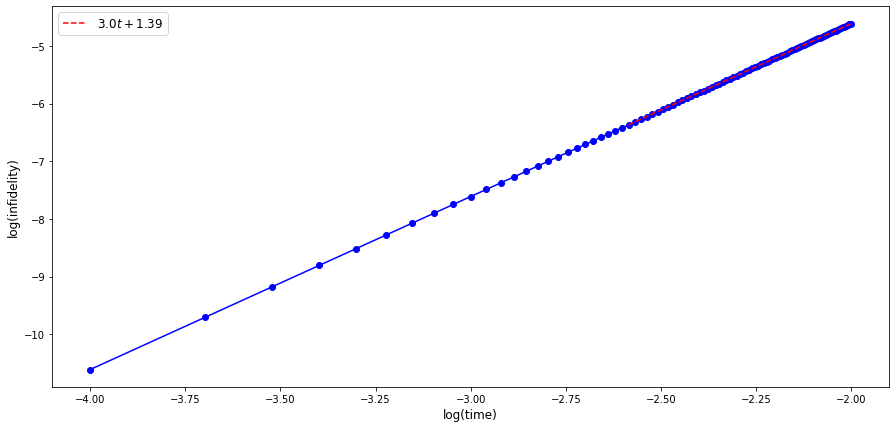

In [68]:
A_Trot_log_infidelity = np.log10(A_Trot_infidel_t)
A_Trot_log_time = np.log10(times)

plt.figure(figsize = (15, 7))
plt.plot(A_Trot_log_time, A_Trot_log_infidelity, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 25 #declare the starting point to fit in the data

p = np.polyfit(A_Trot_log_time[fit_points: -1], A_Trot_log_infidelity[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(A_Trot_log_time[fit_points], A_Trot_log_time[-1], 50)
y_new = f(t_new)

A_Trot_log_time = symbols("t")
poly = sum(S("{:6.2f}".format(v))*A_Trot_log_time**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [55]:
#Evaluate Trotter performance for varying t
del t
del Psi_t
startTime = time.time()

tStart = 0.01
tFinal = 30
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)
temp_t = 3

r = 4000
#int(((temp_t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive
Trot_infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(1j*Y*t)) @ V_i_dagger @ InitialState #recalculate the exact solution
    Trot_infidel = S2_Comp(hj, Hlist, t, r, Psi_t)
    Trot_infidel_t.append(Trot_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 7.290292978286743


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


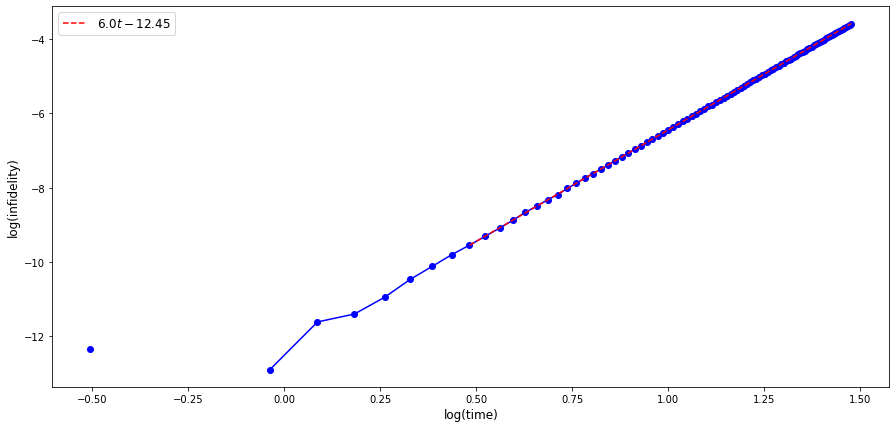

In [56]:
#print(Trot_infidel_t)
Trot_log_infidelity = np.log10(Trot_infidel_t)
Trot_log_time = np.log10(times)

plt.figure(figsize = (15, 7))
plt.plot(Trot_log_time, Trot_log_infidelity, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 10 #declare the starting point to fit in the data

p = np.polyfit(Trot_log_time[fit_points: -1], Trot_log_infidelity[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(Trot_log_time[fit_points], Trot_log_time[-1], 50)
y_new = f(t_new)

A_Trot_log_time = symbols("t")
poly = sum(S("{:6.2f}".format(v))*A_Trot_log_time**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [ ]:
#Evaluate Trotter performance for varying r
startTime = time.time()

t_fixed = 1
r = (((t_fixed**3)* 4 * (gamma**4))/(epsilon * 3)) * (alphacomm/10) #omit alphacomm if prohibitive, omiited int to avoid rounding error
Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t_fixed)) @ V_i_dagger @ InitialState

rStart = 0.00001 * r
rFinal = 0.01 * r
rSteps = 100
rValues = np.linspace(rStart, rFinal, rSteps)
rValues = [int(y+1) for y in rValues]

Trot_infidel_r = []
for i in rValues:
    Trotter_infidel = S2_Comp(hj, Hlist, t_fixed, i, Psi_t)
    Trot_infidel_r.append(Trotter_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

In [ ]:
plt.figure (figsize = (15, 7))
plt.plot(np.log10(rValues), np.log10(Trot_infidel_r), "bo-") #Remove the squared to simply see the wavefunction
plt.xlabel('log(r)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

## Notebook using compilers.py

The goal is to compare the functions in compilers.py to the ones witten here in both output and runtimes. The only part of the previous sections that this section will reference is "Hamiltonian Initialization"

### Trotter Simulation

In [4]:
from compilers import TrotterSim

In [5]:
#Example, does not need to be run
#use array hamiltonian_list
sim = TrotterSim([np.array([[0,1], [1,0]])])
print(sim.simulate(np.pi / 2, 4)) #output state should be sigma_X |0> = |1>

[[0.+0.j]
 [0.+1.j]]


In [6]:
sim1 = TrotterSim(hamiltonian_list, 6)
#sim1.initial_state = InitialState

In [7]:
startTime = time.time()

tStart = 0.0001
tFinal = 0.5
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)

trot_compiler_inf = []
for t in times:
    trot_compiler_inf.append(sim1.infidelity(t, 1))

log_trot_compiler_inf = np.log10(trot_compiler_inf)
log_times = np.log10(times)
print(log_trot_compiler_inf.shape)

data = log_trot_compiler_inf[:, 0, 0]

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(100, 1, 1)
Execution time in seconds: 1.2611520290374756


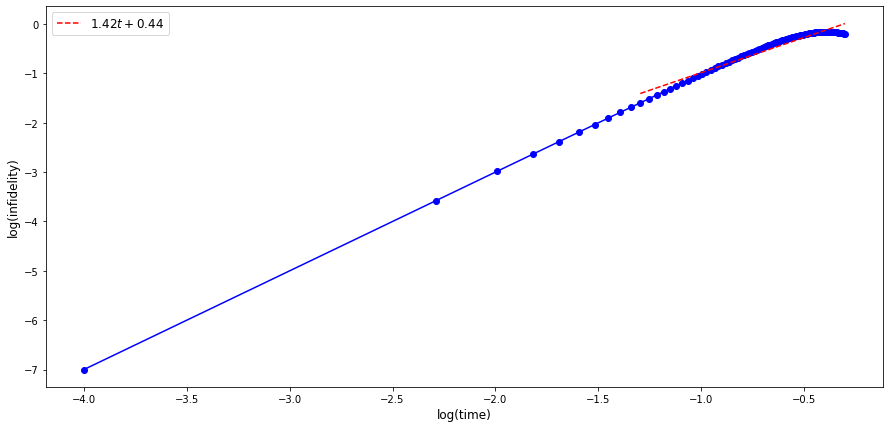

In [8]:
plt.figure(figsize = (15, 7))
plt.plot(log_times, data, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 10 #declare the starting point to fit in the data

p = np.polyfit(log_times[fit_points: -1], data[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[fit_points], log_times[-1], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [23]:
po = sum(hamiltonian_list) @ InitialState
print(po)

op = np.matmul(sum(hamiltonian_list), InitialState.reshape((4, 1)))
print(op)

[ 4.94974747  4.24264069 -0.70710678  0.        ]
[[ 4.94974747]
 [ 4.24264069]
 [-0.70710678]
 [ 0.        ]]


### QDrift Simulation

In [4]:
from compilers import QDriftSimulator

In [5]:
QDsim = QDriftSimulator(hamiltonian_list)
QDsim.simulate(1, 1000)

array([[0.36340479+0.71730382j],
       [0.14723754+0.50873945j],
       [0.11122723-0.0034909j ],
       [0.02966142-0.24424165j]])

In [14]:
QDsim.sample_channel_inf(1, 1, 40)

array([[0.4852464]])

In [69]:
startTime = time.time()

tStart = 0.0001
tFinal = 0.05
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps) #using logspace seems to break the scaling in the figure?

qd_compiler_inf = []
for t in times:
    qd_compiler_inf.append(QDsim.sample_channel_inf(t, 10, 200))

log_qd_compiler_inf = np.log10(qd_compiler_inf)
log_times = np.log10(times)
print(log_qd_compiler_inf.shape)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(100, 1, 1)
Execution time in seconds: 62.13707208633423


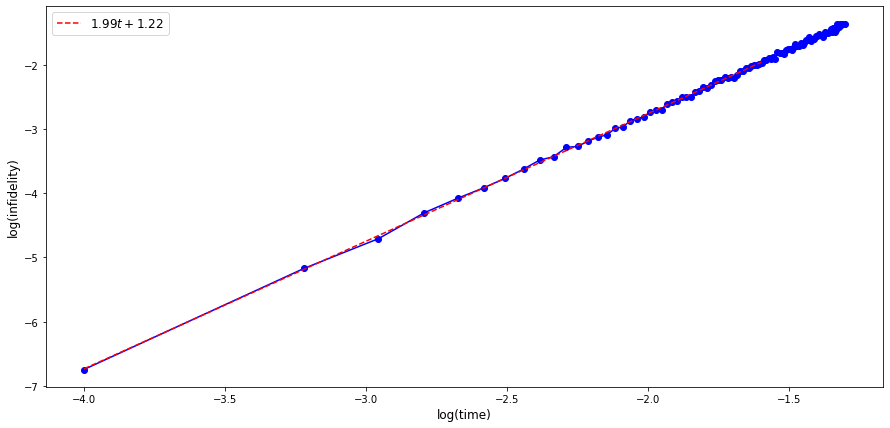

In [70]:
data1 = log_qd_compiler_inf[:, 0, 0]
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 0 #declare the starting point to fit in the data

p = np.polyfit(log_times[fit_points: -50], data1[fit_points: -50], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[fit_points], log_times[-50], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()